# **REDES NEURONALES 2020**

### *Alumno*: Pablo N. Rosa
### *Profesor*: Francisco A. Tamrit


### PRÁCTICO 3

##**Resumen**

En este práctico se implementó una red feed-forward autoencoder con *una* sóla capa oculta para aprender la función identidad de la base de datos *MNIST* de dígitos escritos a mano y digitalizados. Las capas de entradas y salida tuvieron $784$ neuronas y la capa oculta tuvo diferentes número de neuronas: $64, 128, 256, 512$. Para evitar el sobreajuste, se uso dropout $p= 0.1$ como método de regularización. Se aplicó Descenso de Gradiente Estocástico para minimizar la función de Error Cuadrático Medio (ECM) o Mean Squared Error (MSE) al entrenar el modelo. Se graficó esta función error en función del número de épocas, tanto para conjunto de aprendizaje como para el conjunto de test, para evaluar la performance de los autoencoders en función del número de capas ocultas. 

## **Autoencoders**

Los *Autoencodores* son una variante de las redes neuronales usados generalmente para aprender de manera eficiente los datos codificados de una forma *auto-supervisada*, pues los target que queremos generar son los inputs, sin modificar. 

Él debe encontrar la función que asigna el conjunto de inputs o *features* a sí mismo, es decir, debe aprender la función identidad. Este objetivo se conoce como *reconstrucción*, y es capaz de lograrlo mediante el siguiente proceso:
  1. Un **Encoder** (codificador) aprende la representación de datos en un espacio de menor dimensión, es decir, extrae las características más destacadas de los datos. Puede ser visto como una funcion $h = f(x)$ donde $x$ es algún input.
  2. Un **Decoder** (decodificador) aprende a reconstruir los datos originales basándose en la representación aprendida por el codificador. En terminos de funciones, $r = g(h)$ donde $h$ es la salida que produce el encoder.

Si el autoencoder aprende $g(f(x)) = x$ para cualquier $x$, esto no es especialmente útil. En lugar de eso, los autoencoders son diseñados para aprender a copiar imperfectamente. Para ellos en general, son 
restringidos de forma tal que puedan copiar aproximadamente, y copiar solo
entradas que se asemejen a los datos de entrenamiento. Debido a que se fuerza al modelo a priorizar qué aspectos de la entrada deben imitarse, a menudo aprende propiedades útiles de la datos de entrada.

Resumiendo, no estamos interesados en el output de los autoencoders. En lugar de ello, esperamos que el entrenamiento del autoencoder en la tarea de copiar los inputs resulte en una función $h$ que contenga propiedades valiosas de los datos.

Una forma de hacer esto es restringir para que $h$ tenga una dimensión menor que $x$.

El proceso de aprendizaje consiste en minimizar la función pérdida:

$$L(x, g(f(x))$$

donde $L$ es un funcion loss o error que penaliza a $g(f(x))$ por ser distinta de x.

Los autoencoders se han aplicado con éxito a la reducción de dimensionalidad y a las tareas de recuperación de información, entre otras aplicaciones novedosas.

La arquitectura de los autoencoders que implementaremos aquí se corresponde con la de una red neural feedforward, teniendo una capa de entrada, una capa de salida y una o más capas ocultas que las conectan entre sí, donde el número de neuronas en la capa de entrada es el mismo que en la capa de salida.

### El dataset: **MNIST**

La base de datos [MNIST](http://yann.lecun.com/exdb/mnist/)
fue elaborada por el Instituto Nacional de Estándares y Tecnología (National Institute of Standards and Technology). Ésta contiene 60000 imágenes en el conjunto de entrenamiento y 10000 imágenes en el conjunto de test. 
Las imágenes son de $28 \times 28$ píxeles en blanco y negro. Estas images tienen etiquetas que van del $0$ al $9$ y que se corresponden con el dígito que respresentan. Estas etiquetas no nos interesan, para el problema de construir autoencoders.

Para obtener esta base se la descarga módulo ```dataset``` de ```torchvision```. Además se seteraron algunos parámetros para la reproducibilidad del código.

In [1]:
import torch
import torchvision.datasets as datasets

seed = 1234
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
mnist_data_train = datasets.MNIST('./data', train=True, download=True)
mnist_data_test = datasets.MNIST('./data', train=False, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Verificamos el tamaño de los datasets.

In [3]:
print("* El tamaño del conjunto de entrenamiento:", len(mnist_data_train))
print("* El tamaño del conjunto de test:", len(mnist_data_test))

* El tamaño del conjunto de entrenamiento: 60000
* El tamaño del conjunto de test: 10000


Visualicemos algunas imágenes del dataset. Se debe tener en cuenta que las imágenes vienen con el formato ```PIL``` (*Python Imaging Library, the PIL package*).

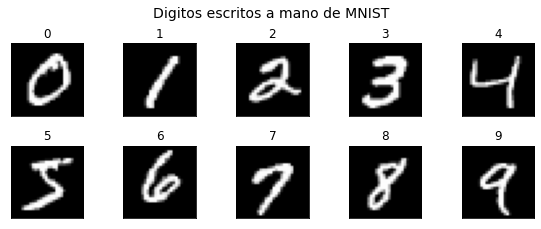

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class_names = list(range(10))

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in mnist_data_train if label == i)
    plt.imshow(img, cmap='gray')
fig.suptitle('Digitos escritos a mano de MNIST', 
             va="bottom", ha="center", fontsize=14)
plt.tight_layout()
plt.show()

### Transformación de los datos

Para implementar la red neuronal se usará [Pytorch](https://pytorch.org/).Para ello, las imágenes PIL deben ser "vectorizadas" en *tensores*. Para ellos usamos la función, ```transforms.ToTensor()```.

In [5]:
from torchvision import transforms

tensor_train = datasets.MNIST('./data', train=True, download=False,
               transform=transforms.ToTensor())
tensor_test = datasets.MNIST('./data', train=False, download=False,
               transform=transforms.ToTensor())

Además es una buena práctica normalizar el dataset para que los datos tengan media 0 y desviación estándar 1.

Para ello podemos computar la media y la desviación estándar de todos los pixeles en el conjunto de entrenamiento y aplicar la siguiente transformación ```v_n = (v - mean) /
stdev```. Esto es lo que hace ```transforms.Normalize```. Los valores de la media y desviación estándar deben  ser computados por separado. Los computamos para nuestro conjunto de entrenamiento (```tensor_train```).

In [6]:
# Concatenamos todos las imágenes, ahora tensores en un solo tensor.
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
# Las dimensiones del nuevo tensor...
imgs.shape

torch.Size([1, 28, 28, 60000])

Ahora podemos computar la media y la desviación estándar, para luego aplicar la normalización. Notemos que se usaron los mismos valores para normalizar el conjunto de test.

In [7]:
mean = np.round(imgs.view(1, -1).mean(dim=1).item(), 4)
std = np.round(imgs.view(1, -1).std(dim=1).item(), 4)
print("* La media calculada:", mean)
print("* La desviación estándar calculada:", std)

* La media calculada: 0.1307
* La desviación estándar calculada: 0.3081


In [8]:
transformed_train = datasets.MNIST('./data', train=True, download=False,
                                   transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((mean),(std))]))
transformed_test = datasets.MNIST('./data', train=False, download=False,
                                   transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((mean),(std))]))

## Autoencoder implementado

Con los datos preparados se implementó una clase ```Autoencoder``` con una capa oculta, y con entradas y salidas de $784$ neuronas. Como queremos probar diferentes tamaños de capas ocultas y evaluar la performance en base a la loss en la reconstrucción, nuestra clase tendrá como parámetro el tamaño de la capa oculta ```num_hidden```. Para evitar el overfitting se usa dropout con $p = 0.1$. Entre las capaz se usa la funcion de activación tangente hiperbòlica ($tanh$) y luego $ReLU$.

In [9]:
from torch import nn

class Autoencoder(nn.Module):
    def __init__(self, num_hidden):
        super(Autoencoder, self).__init__()
        self.hidden = num_hidden
        #Encoder
        self.encoder = nn.Linear(in_features=784,
                                 out_features=num_hidden)
        #Decoder 
        self.decoder = nn.Linear(in_features=num_hidden,
                                 out_features=784)
        # Dropout technique used
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = self.encoder(x)
        coded = torch.tanh(x)
        dropped = self.dropout(coded)
        decoded = self.decoder(dropped)
        reconstructed = torch.relu(decoded)
        return reconstructed

### Entrenamiento

El modelo de autoencoder que implementamos se entrena minimizando el error cuadrático medio (Mean Squared Error - MSE) entre el input original y la salida reconstruida para mesurar el error de reconstrucción. 

Para el entrenamiento usaremos una mejora del algoritmo básico de descenso de gradiente estocástico, llamada, [*Adam*](https://es.qaz.wiki/wiki/Stochastic_gradient_descent#Adam) (*Adaptive Moment Estimation*) que es considerado una actualización del optimizador *RMSProp*. En este algoritmo de optimización, se utilizan promedios de ejecución tanto de los gradientes como de los segundos momentos de los gradientes.

Para ello definimos una funcion que nos crea un autoencoder con el tamaño de capa oculta que deseamos. Tambien creamos minibatches de tamaño $1000$.

In [10]:
from torch import optim

# Tasa de aprendizaje - Hiperparametro del modelo
# Aunque es el valor por default en Adam
learning_rate = 1e-3

def create_autoencoder(hidden_num, learning_rate, device):
  # Creamos el modelo instanciando la clase y lo cargamos al dispositivo
  net = Autoencoder(hidden_num).to(device)
  # Creamos el optimizador Adam con los parámetros de la red
  # El resto de los parámetros queda en default.
  optimizer = torch.optim.Adam(net.parameters(),
                               lr=learning_rate)
  # La funcion loss a usar es el error cuadrático medio
  criterion = nn.MSELoss()
  return net, optimizer, criterion

In [11]:
batch_size = 1000

# creamos minibatches para entrenamiento y test
train_loader = torch.utils.data.DataLoader(transformed_train,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(transformed_test,
                                          batch_size=batch_size,
                                          shuffle=True)

Se define una función ```training``` que entrena un autoencoder red con un numero ```num``` determinado de neuronas en la capa oculta, una determinada cantidad de épocas ```epochs```. La función retorna dos listas, ```train_losses``` con los errores de cada época en el conjunto de entrenamiento y ```test_losses```, con los errores en el conjunto de test. El error en una epoca es el promedio de los errores de todos los minibatches, esto es así tanto para train como para test. Notar que el error de test se obtiene una vez que se entreno a la red en una época.

In [12]:
def training(num, train_loader, test_loader, epochs):
  # creamos listas vacias para almacenar los errores
  train_losses = []
  test_losses = []
  # Usar GPU si esta disponible
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  net, optimizer, criterion = create_autoencoder(num, learning_rate, device) 
  print('*** Entrenando autoencoder con', net.hidden, 
        'neuronas en la capa oculta ***')
  
  for epoch in range(1, epochs+1):
    # loss es la perdida promedio por época
    loss = 0
    # seteamos la red en modo training
    net.train()
    # iteremos sobre todos los minibatches...
    for batch_features, _ in train_loader:
      # reformamos el mini-batch a una matriz [N, 784]
      # y lo cargamos en un dispositivo activo.
      batch_features = batch_features.view(-1, 784).to(device)
      # en cada epoca se resetean los gradientes a cero
      optimizer.zero_grad()
      # computamos las reconstrucciones
      outputs = net(batch_features)
      # computamos la loss de la reconstruccion
      train_loss = criterion(outputs, batch_features)
      # realizamos backpropagation de los errores
      train_loss.backward()
      # actualizamos los parámetros
      optimizer.step()  
      # acumulamos los errores de los minibatches.
      loss += train_loss.item()
        
    # promediamos el error de entrenamiento en la epoca
    # diviendo por el numero de minibatches.
    loss = loss / len(train_loader)
    train_losses.append(loss)
    if (epoch == 1) or (epoch % 5 == 0):
      print("\t * Epoch : {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

    # seteamos a la red en modo evaluación
    net.eval()
    # no necesitamos calcular el gradiente para evaluar el conjunto de test
    with torch.no_grad():
      loss_test = 0
      for batch_features, _ in test_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        output = net(batch_features)
        # el error se calcula de la misma forma
        loss_test += criterion(output, batch_features).item()
    
      loss_test /= len(test_loader)
      test_losses.append(loss_test)

  return train_losses, test_losses, net  

Con el metodo anterior se crearon cuatro autoencoders con 4 tamaños de capas ocultas: $64, 128, 256, 512$. 

Se entrenaron con 20 épocas y se graficaron los errores.

In [13]:
epochs = 20

hidden_num = [64, 128, 256, 512]
nets = []
train_errors = np.zeros((len(hidden_num), epochs))
test_errors = np.zeros((len(hidden_num), epochs))

for idx, num in enumerate(hidden_num):
  train_losses, test_losses, net = training(num, train_loader, 
                                            test_loader, epochs)
  nets.append(net) 
  train_errors[idx] = train_losses
  test_errors[idx] = test_losses

*** Entrenando autoencoder con 64 neuronas en la capa oculta ***
	 * Epoch : 1/20, loss = 0.734085
	 * Epoch : 5/20, loss = 0.350996
	 * Epoch : 10/20, loss = 0.291000
	 * Epoch : 15/20, loss = 0.270887
	 * Epoch : 20/20, loss = 0.261588
*** Entrenando autoencoder con 128 neuronas en la capa oculta ***
	 * Epoch : 1/20, loss = 0.634671
	 * Epoch : 5/20, loss = 0.262960
	 * Epoch : 10/20, loss = 0.227395
	 * Epoch : 15/20, loss = 0.216510
	 * Epoch : 20/20, loss = 0.211272
*** Entrenando autoencoder con 256 neuronas en la capa oculta ***
	 * Epoch : 1/20, loss = 0.533254
	 * Epoch : 5/20, loss = 0.212021
	 * Epoch : 10/20, loss = 0.190873
	 * Epoch : 15/20, loss = 0.184203
	 * Epoch : 20/20, loss = 0.180593
*** Entrenando autoencoder con 512 neuronas en la capa oculta ***
	 * Epoch : 1/20, loss = 0.442163
	 * Epoch : 5/20, loss = 0.183937
	 * Epoch : 10/20, loss = 0.169974
	 * Epoch : 15/20, loss = 0.165170
	 * Epoch : 20/20, loss = 0.163060


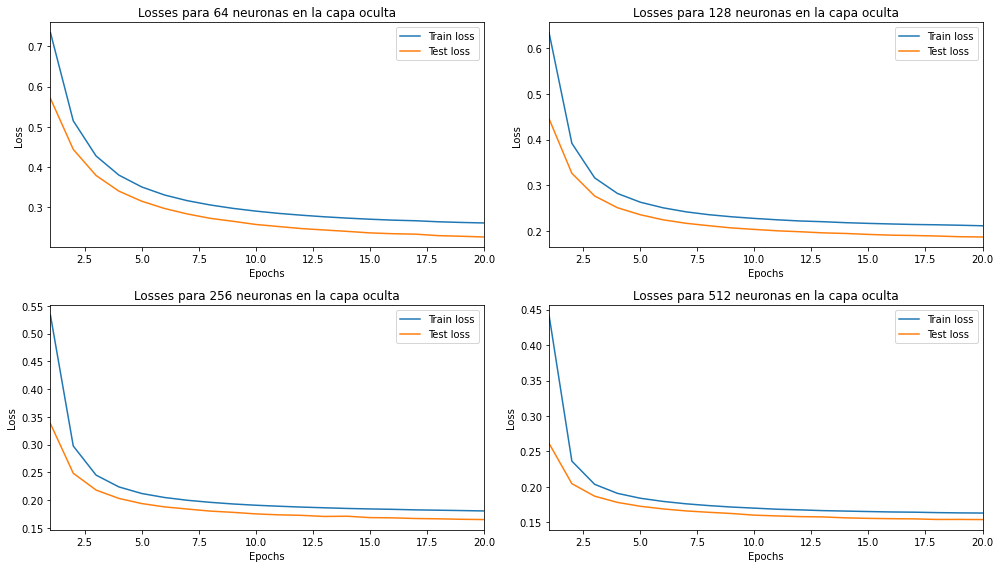

In [14]:
fig = plt.figure(figsize=(14, 8))
for idx, (train, test) in enumerate(zip(train_errors, test_errors)):
  ax = fig.add_subplot(2, 2, idx+1)
  ax.plot(np.arange(1, 21), train, label='Train loss')
  ax.plot(np.arange(1, 21), test, label='Test loss')
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_xlim(1, epochs)
  ax.legend()
  ax.set_title('Losses para ' + 
               str(nets[idx].hidden) + 
               ' neuronas en la capa oculta')
fig.tight_layout()

En estos gráficos podemos observar, que las curvas de loss test, se ubicaron siempre por debajo de las loss train. Un buen ajuste se identifica por una loss train y loss test que disminuyen hasta un punto de estabilidad con una brecha mínima entre los dos valores finales de loss. Aunque no se observa una brecha muy mínima, si se alcanza a ver estabilidad. Una razon por la que la loss test se halle por debajo de su correspondiente loss train, puede ser la regularización que se está usando: la técnica del dropout. Ya que cuando se evalua la red (```net.eval()```), se desactiva el dropout. De cualquiera manera no se observa overfitting en algún autoencoder, lo que ocurriría si la loss test fuera mayor a su correspondiente train en algun caso.

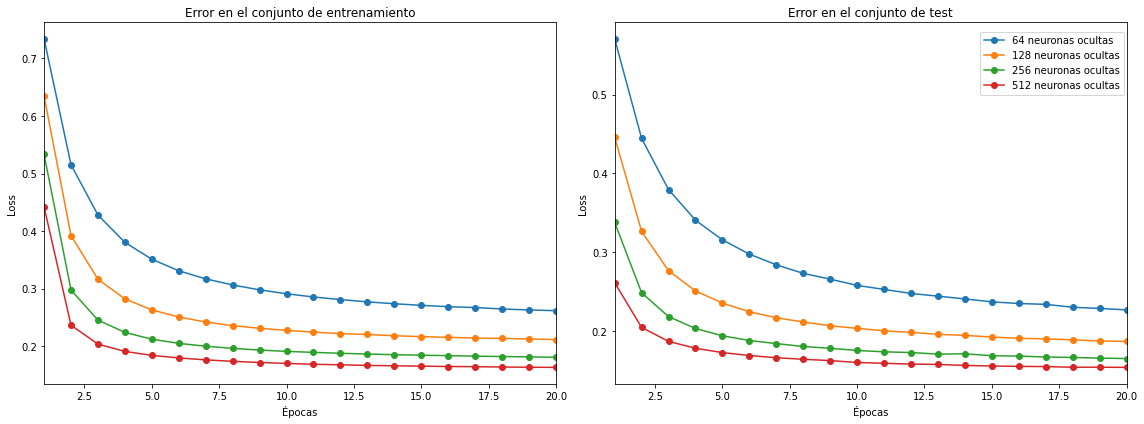

In [15]:
fig = plt.figure(figsize=(16, 6))

for idx, errors in enumerate([train_errors, test_errors]): 
  ax = fig.add_subplot(1, 2, idx+1)
  for error, hidden in zip(errors, hidden_num):
    if idx == 1:
      ax.plot(np.arange(1, 21), error, 'o-', label=str(hidden) +
              ' neuronas ocultas')
      ax.set_title('Error en el conjunto de test')
    else:
      ax.plot(np.arange(1, 21), error, 'o-')
      ax.set_title('Error en el conjunto de entrenamiento')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('Loss')
    ax.set_xlim(1, 20)
fig.legend(loc='upper right', bbox_to_anchor=(0.5, 0.6, 0.48, 0.32))
fig.tight_layout();

Estos gráficos nos permiten comparar las magnitudes de los errores para los diferentes tamaños de capas. Las magnitudes de los errores resultaron inversamente proporcional al número de neuronas en la capa oculta, tanto para el entrenamiento y test. Con el mismo número de épocas, las redes con más neuronas en sus capas ocultas alcanzaron una loss menor que las con menos neuronas. La diferencia en la última época de la loss para la red con menos neuronas y la con mas es del orden de $10^{-1}$.

A su vez como vimos anterioremente, en los conjuntos de test, las loss fueron menores que sus correspondientes en los conjuntos de entrenamiento.

Por últimó para tener una idea del aprendizaje de los autoencoders, visualizamos como reconstruyen algunas imágenes del conjunto de test.

In [16]:
# Usar GPU si esta disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_examples = None
reconstructions = []
with torch.no_grad():
  for batch_features, _ in test_loader:
    test_examples = batch_features.view(-1, 784).to(device)
    for net in nets:
      reconstruction = net(test_examples)
      reconstructions.append(reconstruction)
    break

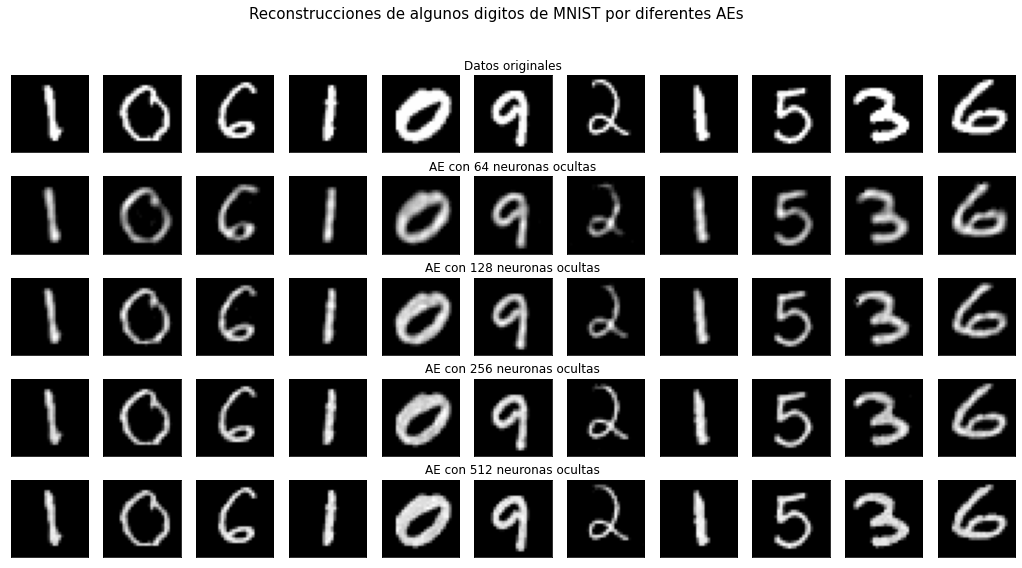

In [17]:
with torch.no_grad():
  number = 11
  plt.figure(figsize=(18, 9))
  for index in range(number):
    # display original
    ax = plt.subplot(5, number, index + 1)
    plt.imshow(test_examples[index].cpu().data.numpy().reshape(28, 28))
    plt.gray()
    if index == 5:
        ax.set_title('Datos originales')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstructions
    for idx, (reconstruction, net) in enumerate(zip(reconstructions, nets)):
      ax = plt.subplot(5, number, index + 1 + ((idx+1)*number))
      plt.imshow(reconstruction[index].cpu().data.numpy().reshape(28, 28))
      plt.gray()
      if index == 5:
        ax.set_title('AE con ' + str(net.hidden) + ' neuronas ocultas')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
plt.suptitle('Reconstrucciones de algunos digitos de MNIST por diferentes AEs', 
             fontsize=15, ha='center')
plt.show()

A medida que aumenta el número de capas, las reconstrucciones agregan más detalles.

### **Conclusión**

En este trabajo se entrenaron autoencoders con distintas *capacidades*. La capacidad de un modelo es el número de parámetros a aprender que tiene. Al aumentar el número de capas ocultas, estamos aumentando la capacidad de la red. Intuitivamente un modelo con más parámetros, tiene más capacidad de memorización y por lo tanto puede aprender facilmente un dicctionario de mapeo entre los datos de entrenamiento y sus valores target, pero quizás sin ningun poder de generalización. Lo mismo ocurre con los autoencoders, un autoencoder entrenado para copiar los datos de entrada puede fallar en aprender algo útil del dataset, si la cacapcidad del modelo se incrementa demasiado. De esta forma, aunque el autoencoder con $512$ neuronas logra la menor loss, no reduce mucho la dimensión del dataset y probablemente no haya aprendido representaciones útiles; por otra parte, el autoencoder de $64$ neuronas, con una loss algo mayor, logró reducir en gran medida la dimensionalidad.